In [212]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import geopandas as gpd
import urllib
import glob
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from shapely.geometry import Point, LineString
import scipy
import glob
# import jenkspy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
!mkdir download_data
!wget http://streetscore.media.mit.edu/static/files/streetscore_data.zip -O streetscore_data.zip
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile', 'download_data/precinct.zip')
# urllib.request.urlretrieve('http://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/c-summonses/criminal-court-summons-2007-through-q1-2017.xlsx', 'download_data/crime.xlsx')
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD', 'download_data/crime.csv')
!mv streetscore_data.zip download_data
zf = ZipFile('download_data/streetscore_data.zip')
zf2 = ZipFile('download_data/precinct.zip')
zf.extractall('download_data/')
zf2.extractall('download_data/')

mkdir: cannot create directory ‘download_data’: File exists
--2018-12-10 12:21:53--  http://streetscore.media.mit.edu/static/files/streetscore_data.zip
Resolving streetscore.media.mit.edu (streetscore.media.mit.edu)... 18.85.28.79
Connecting to streetscore.media.mit.edu (streetscore.media.mit.edu)|18.85.28.79|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4754382 (4.5M) [application/zip]
Saving to: ‘streetscore_data.zip’

streetscore_data.zi 100%[===================>]   4.53M  11.4MB/s    in 0.4s    

2018-12-10 12:21:53 (11.4 MB/s) - ‘streetscore_data.zip’ saved [4754382/4754382]



In [451]:
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', 'download_data/puma.zip')
zf3 = ZipFile('download_data/puma.zip')
zf3.extractall('download_data/')

In [3]:
#puma data
puma = gpd.read_file(glob.glob('download_data/*.shp')[0])

In [4]:
# ss refers to safety score
ss = pd.read_csv('download_data/streetscore_dataset/streetscore_newyorkcity.csv')
ss.head()

,latitude,longitude,q-score
0,40.700909,-74.013504,11.062166
1,40.701000,-74.013878,10.818611
2,40.701080,-74.012878,12.677955
3,40.701187,-74.013268,11.417325
4,40.701244,-74.012115,25.199091


In [ ]:
breaks = jenkspy.jenks_breaks(ss['q-score'].values, nb_class=5)
breaks[5] = breaks[5] + 1

In [ ]:
# use jenks natrual break to classify the perceived safety score
def jenk_lable(y):
#     lables = []
#     breaks = jenkspy.jenks_breaks(ss['q-score'].values, nb_class=n-1)
#     breaks[n-1] = breaks[n-1] + 1
#     np.array(breaks) + 0.1
    breaks = [-4.0, 18.451204, 23.012817000000002, 26.877476, 31.340740000000004, 44.0]
    for k in range(1,5):

        if y['q-score'] >= breaks[k-1] and y['q-score'] < breaks[k]:
            return k
        else:
            pass

In [ ]:
ss['class'] = ss.apply(jenk_lable, axis=1)
ss.to_csv('jenk.csv', sep=',')

In [5]:
ss = pd.read_csv('jenk.csv')

In [6]:
# violence related felony dataset
felony = pd.read_csv('download_data/felony.csv')
felony = felony[['Latitude', 'Longitude', 'ADDR_PCT_CD', 'CMPLNT_FR_DT']]
felony.dropna(subset=['CMPLNT_FR_DT'], inplace=True)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def get_2011(felony):
    return felony['CMPLNT_FR_DT'][-2:]
felony['2011'] = felony.apply(get_2011, axis=1)
felony_11 = felony[felony['2011'] == '11']

In [9]:
geometry = [Point(xy) for xy in zip(felony_11.Longitude, felony_11.Latitude)]
felony_11 = felony_11.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
felshp = gpd.GeoDataFrame(felony_11, crs=crs, geometry=geometry)

In [10]:
felshp = felshp[felshp['Latitude'] < 41]

In [11]:
fels = gpd.sjoin(puma, felshp, how='left', op='intersects')

In [12]:
geometry = [Point(xy) for xy in zip(ss.longitude, ss.latitude)]
linkNYC = ss.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
ssshp = gpd.GeoDataFrame(ss, crs=crs, geometry=geometry)

In [13]:
ssshp.head()

,Unnamed: 0,latitude,longitude,q-score,class,geometry
0,0,40.700909,-74.013504,11.062166,1.0,POINT (-74.013504 40.700909)
1,1,40.701000,-74.013878,10.818611,1.0,POINT (-74.01387800000001 40.701)
2,2,40.701080,-74.012878,12.677955,1.0,POINT (-74.012878 40.70108)
3,3,40.701187,-74.013268,11.417325,1.0,POINT (-74.01326800000002 40.701187)
4,4,40.701244,-74.012115,25.199091,3.0,POINT (-74.01211500000002 40.701244)


In [14]:
ssshp = ssshp.dropna()
ssshp = ssshp[['q-score', 'class', 'geometry']]
ssshp.head()

,q-score,class,geometry
0,11.062166,1.0,POINT (-74.013504 40.700909)
1,10.818611,1.0,POINT (-74.01387800000001 40.701)
2,12.677955,1.0,POINT (-74.012878 40.70108)
3,11.417325,1.0,POINT (-74.01326800000002 40.701187)
4,25.199091,3.0,POINT (-74.01211500000002 40.701244)


In [135]:
len(ssshp)

290673

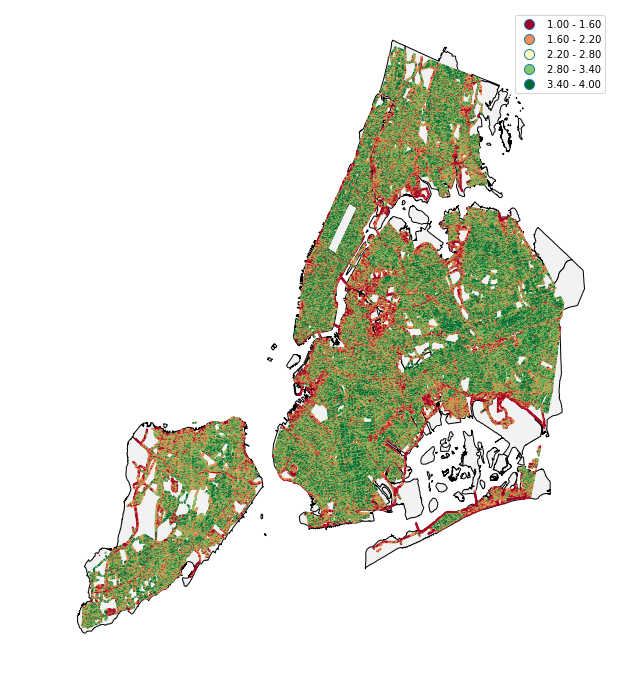

In [464]:
fig,ax = plt.subplots(figsize=(10,12))

puma.to_crs(epsg=2263).plot(ax=ax,edgecolor='black', color='#f2f2f2')
ssshp.to_crs(epsg=2263).plot(ax=ax,column='class',marker='.',markersize=1,cmap='RdYlGn',scheme='Equal_interval', legend=True)

plt.axis('off')
plt.savefig('1.png')

### Figure 1. This plot shows the perceived safety score' distritbution in New York City. The greener points means higher perceived safety score at that location and the redder points means the lower perceived safety score.

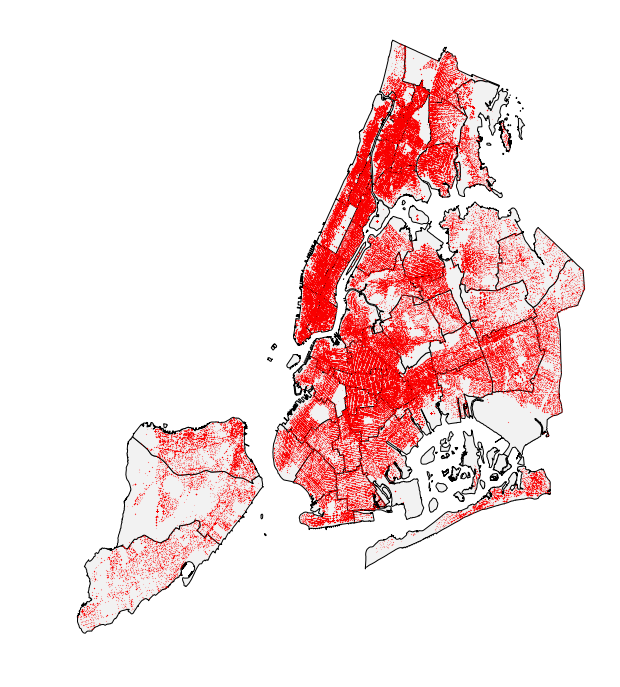

In [450]:
fig,ax = plt.subplots(figsize=(10,12))

puma.to_crs(epsg=2263).plot(ax=ax,edgecolor='black', color='#f2f2f2')
felshp.to_crs(epsg=2263).plot(ax=ax, color='red', marker='.',markersize=0.02)

plt.axis('off')
plt.savefig('2.png')

In [430]:
felshp.head()

,Latitude,Longitude,ADDR_PCT_CD,CMPLNT_FR_DT,2011,geometry
index_right,,,,,,
307,40.708673,-73.958580,90.0,10/05/2011,11,POINT (-73.95857955300001 40.708673331)
5782,40.817942,-73.847785,43.0,09/23/2011,11,POINT (-73.847785022 40.817941833)
7238,40.648867,-73.950822,67.0,01/01/2011,11,POINT (-73.95082190000001 40.648867133)
8705,40.722610,-73.992339,5.0,11/01/2011,11,POINT (-73.992338743 40.722610191)
10217,40.675571,-73.925779,77.0,05/01/2011,11,POINT (-73.925778983 40.67557139199999)


In [200]:
#count the felony amount in each zip code
y = fels.groupby(['puma']).count()['2011'].values

In [16]:
#calculate the relative score of perceived safety
ss_puma = gpd.sjoin(ssshp, puma, how='right', op='intersects')

In [152]:
puma = puma.to_crs(epsg=2263)
size = np.array(puma['geometry'].area.values)

In [201]:
score = ss_puma.groupby(['puma','class']).count()['q-score'].values.reshape(55,4)
count = score.sum(axis = 1)
score_r = []
for i in range(55):
    score_r.append(score[i] / count[i])
    
score_r = np.array(score_r)

y = y/size

In [202]:
# preprocessing: standardize and whiten
X = StandardScaler().fit_transform(score_r.T)
X = StandardScaler().fit_transform(X.T)

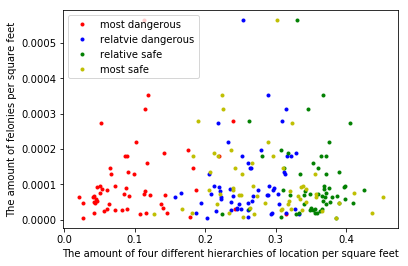

In [203]:
df = pd.DataFrame(score_r)
df['felony'] = y
plt.plot(df[0], df['felony'], 'r.', label='most dangerous')
plt.plot(df[1], df['felony'], 'b.', label='relatvie dangerous')
plt.plot(df[2], df['felony'], 'g.', label='relative safe')
plt.plot(df[3], df['felony'], 'y.', label='most safe')
plt.xlabel('The amount of four different hierarchies of location per square feet')
plt.ylabel('The amount of felonies per square feet')
plt.legend()
plt.savefig('4class.png')

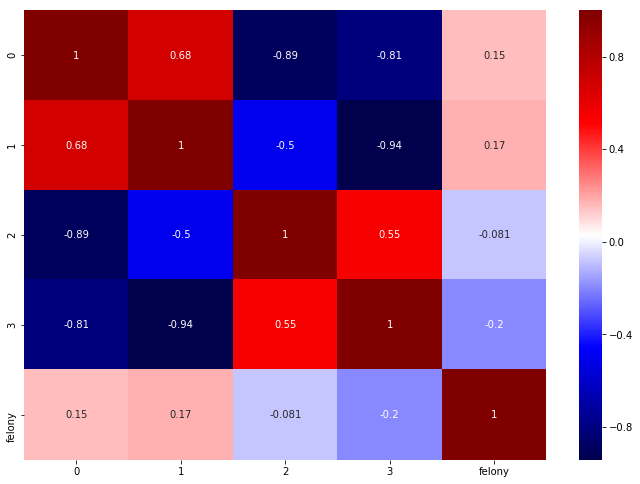

In [208]:
corr_df = df.corr()
fig,ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
# ax = sns.heatmap(TEMP_data)
#ax = sns.heatmap(temp_data)
#beijing_pm.head()
#df = pd.pivot_table(beijing_pm,values='PM25',index='iWS',columns='TEMP')
ax = sns.heatmap(corr_df,cmap='seismic',annot=True,)

In [209]:
x = PolynomialFeatures(degree=4, interaction_only=False, include_bias=True).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
X_vali, X_test, y_vali, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
alphas = np.exp(np.linspace(-40,0))
best = {}
for alfa in alphas:
    sklearn_lasso = Lasso(fit_intercept=False,alpha=alfa,normalize=False)
    model = sklearn_lasso.fit(X_train,y_train)
#     predict_y = model.predict(X_test)
    predict_R2 = model.score(X_vali,y_vali)
#     R2 = model.score(X_train,Y_train)
#     return predict_R2
    best[predict_R2] = alfa



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.

In [210]:
print('best alpha:', best[sorted(list(best.keys()))[-1]])
print('best R2:', sorted(list(best.keys()))[-1])
best_alfa = best[sorted(list(best.keys()))[-1]]

best alpha: 5.56783950244e-05
best R2: -0.0380373523714


In [211]:
sklearn_lasso = Lasso(fit_intercept=True,alpha=best_alfa,normalize=False)
model = sklearn_lasso.fit(X_train,y_train)
predict_y = model.predict(X_test)
predict_R2 = model.score(X_test,y_test)
R2 = model.score(X_train,y_train)
#     R2 = model.score(X_train,Y_train)
#     return predict_R2
print('alpha=',best_alfa)
print('Train R2:',R2)
print('Test R2:',predict_R2)

alpha= 5.56783950244e-05
Train R2: 0.100988032329
Test R2: -0.00833372814783


In [196]:
sklearn_lasso.coef_


array([  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -1.60940396e-05,  -2.73301599e-06,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.13418451e-05,  -1.33417359e-05,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -3.90931340e-05])

In [221]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [222]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.049
Date:                Fri, 14 Dec 2018   Prob (F-statistic):              0.379
Time:                        15:37:48   Log-Likelihood:                 429.77
No. Observations:                  55   AIC:                            -851.5
Df Residuals:                      51   BIC:                            -843.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.37e-05      7.675      0.0